In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# The following notebook focuses on the second quantization representation for quantum systems

### We consider the non interacting free Bosons system with the following Hamiltonian for k lattice sites in 1 dimension

$$
\Large H = \tau_k\sum_{k} a^\dagger_{k} a_{k+1} + a_{k} a^\dagger_{k+1}
$$

For example for 3 lattice sites that have periodic boundary conditions with $\tau=1$ for all terms for ease of computations, expanding this gives:

$$
a^\dagger_{1} a_{2} + a_{1} a^\dagger_{2} + a^\dagger_{2} a_{3} + a_{2} a^\dagger_{3} + a^\dagger_{3} a_{1} + a_{3} a^\dagger_{1}
$$

Hence when contracing the Hamiltonian with 2 states $|i>, |j>$ to get its matrix elements what we have to solve is

$$
<i| a^\dagger_{1} a_{2} + a_{1} a^\dagger_{2} + a^\dagger_{2} a_{3} + a_{2} a^\dagger_{3} + a^\dagger_{3} a_{1} + a_{3} a^\dagger_{1} |j>
$$

expanding this gives

$$
<i|a^\dagger_{1} a_{2}|j> + <i|a_{1} a^\dagger_{2}|j> + <i|a^\dagger_{2} a_{3}|j> + <i|a_{2} a^\dagger_{3}|j> + <i|a^\dagger_{3} a_{1}|j> + <i|a_{3} a^\dagger_{1}|j>
$$

Looping through all basis states |1>, |2>, ..., |i>,..., |j>, ...  will give us all i,j indexed pairs of the Hamiltonian Operator explicitly

It is clear here that in order to compute these terms we simply need functions regarding the creation and annahilation operators and how they transform states.

Let us take bosonic states for example and how they transform under these operators.

- Creation operator     : $a^\dagger_{k}|...,n_{k},...> = \sqrt{n_k + 1}|...,n_{k}+1,...>$
- Annahilation operator : $a_{k}|...,n_{k},...> = \sqrt{n_k}|...,n_{k}-1,...>$

These definitions allow us to create states from any initial state. The next step is to create an ordered basis

*J M Zhang and R X Dong 2010 Eur. J. Phys. 31 591:  Exact diagonalization: the Bose–Hubbard model as an example*

gives the rules for lexicographical ordering of the basis. The total number of states is calculated through the Combinations with replacement formula:

$$
C^{R}_{(n,r)} = \dfrac{(n+r-1)!}{r!(n-1)!} 
$$

where n (number of objects) are the number of total sites and r (samples) are the number of bosons present in the Fock Space

This kind of truncation allows us to avoid calculating ALL possible states for k sites which for bosonic states is infinite due to the fact that multiple bosons can be stacked in the same state (in this ideal picture). Unlike fermions (all same spin) which can only occupy a single state at a time. Essentially truncating the space by default. We can however abuse the symmetry of particle conservation to truncate the bosonic space if we know the total number of bosons present in the system. We iterate through all possible Combinations with replacement and then order in lexicographical order. This is done very simply with the itertools from python.


The operators are very simply programmed as functions that take a state as input and give a state as output. We also need a "contract_states" function that takes the inner product of 2 states. These are very easily calculated in this representation because the basis is orthogonal and therefore inner products scale with the kroneker delta. So doing this operation is as simple as doing a direct comparison

Now is a good time to talk about the representation on the computer. A struct of type "bstate" is created that holds a pointer to an array of ints. The elements in this array are the direct numbers you find in the symbolic representation. For example the state $\eta|2,0,1,0>$ is directly represented as a struct that holds the information array: $$bstate =\{(2,0,1,0), 4, \eta\}$$
Where eta is the normalization constant front that simply multiplies the state. These are needed due to the application of the operators on the states.

We can see the bstate struct has a size in Bytes of 4+4+8 = 16 Bytes.

However the initial 4 Bytes are to the array pointer which itself can be very large so it is missleading to calculate memory usage with 16 Bytes only

### Note: Because i am very lazy, the states should not exceed an occupation number of 9. Therefore a state like 8,0,0 is pushing the limits of my lazy coding

Now after creating the ordered Basis full of bstate struct objects, getting the Hammiltonian matrix is as Trivial as looping through the basis and using the "contract_states" along with the "apply_creator/annahilator" functions to the basis bstates!

Because states are contracted after all operators are applied, we are guaranteed to get doubles as matrix elements.

In [2]:
%load_ext Cython

# Cell below for bosons

In [3]:
%%cython
cimport cython
from libc.stdlib cimport malloc, free
from libc.math cimport sqrt
from cython cimport sizeof
from itertools import combinations_with_replacement


import numpy as np
cimport numpy as np

##
ctypedef struct bstate:
    int* state
    int size
    double norm_const

##    
cdef void free_bosons(bstate in_state) nogil:
    free(in_state.state)
    in_state.state = NULL

##
cdef print_state(bstate instate):
    for i in range(instate.size):
        print(instate.state[i], end=" ")
    print("\nstate sites =",instate.size,"\nnorm constant in front of state =",instate.norm_const)
    



##
@cython.boundscheck(False)
@cython.wraparound(False)
cdef int factorial(int a) nogil:
    if a == 0:
        return 1
    cdef int result, i
    result = 1
    for i in range(a):
        result = result*(i+1)
    return result
    

##
cdef int bosonic_basis_size(int bosons, int sites) nogil:
    if (bosons<0) or (sites<0):
        raise ValueError("negative sites or occupations")
    cdef int result
    result = (factorial(bosons+sites-1))//(factorial(bosons)*factorial(sites-1))
    return result
##
cpdef int basis_size_python(int nrbosons, int nrsites):
    return bosonic_basis_size(nrbosons, nrsites)

##
@cython.boundscheck(False)
@cython.wraparound(False)
cdef bstate* ordered_basis(int bosons, int sites):
    # Generate all possible combinations of site occupations with replacement
    combinations = list(combinations_with_replacement(range(sites), bosons))

    # Sort the combinations in lexicographic order
    combinations = sorted(combinations)
    cdef int length = len(combinations)

    # Create basis vectors from the sorted combinations
    cdef bstate* basis_vectors = <bstate*>malloc(length*sizeof(bstate))
    
    cdef int i
    for i in range(length):
        basis_vectors[i] = create_bosons("0" * sites, sites)  # Initialize with all zeros
        
        for site in combinations[i]:
            basis_vectors[i].state[site] += 1
            #basis_vectors[i].norm_const = sqrt(<double>basis_vectors[i].state[site]) needed ???? check theory books
    return basis_vectors



##
@cython.boundscheck(False)
@cython.wraparound(False)
cdef bstate create_bosons(str state, int space_size) nogil:
    cdef int* state_array = <int*>malloc(space_size*sizeof(int))
    if state_array is NULL:
        raise MemoryError("Failed to allocate memory for state_array")
    
    for i in range(space_size):
        if state[i] < 0:
            raise ValueError("no negative occupation numbers for bosonic states")
        state_array[i] = <int>state[i]-48 #minus 48 because of ascii encoding from str to int. 0 is 48 in ascii. 1 is 49
    cdef bstate result
    result.state = state_array
    result.size = space_size
    result.norm_const = 1.
    return result


##
cdef bstate apply_creator(bstate in_state, int site) nogil:
    if site <= 0:
        raise ValueError("site number negative or 0")
    #index = site-1
    cdef int i
    cdef bstate cresult
    cresult.size = in_state.size
    cresult.state = <int*>malloc(in_state.size*sizeof(int))
    for i in range(in_state.size):
        cresult.state[i] = in_state.state[i]
    cresult.state[site-1] = in_state.state[site-1]+1
    cresult.norm_const = sqrt(cresult.state[site-1])*in_state.norm_const
    return cresult
##

cdef bstate apply_annahilator(bstate in_state, int site) nogil:
    if site <= 0:
        raise ValueError("site number negative or 0")
    #index = site-1
    cdef bstate aresult
    aresult.size = in_state.size
    aresult.state = <int*>malloc(in_state.size*sizeof(int))
    for i in range(in_state.size):
        aresult.state[i] = in_state.state[i]
    aresult.state[site-1] = in_state.state[site-1]-1

    if in_state.state[site-1] == 0:
        aresult.norm_const = 0.
    else:
        aresult.norm_const = sqrt(in_state.state[site-1])*in_state.norm_const
    return aresult

##
cdef bstate number_operator(bstate in_state, int site, int power) nogil:
    #index = site-1
    cdef bstate nresult
    nresult.size = in_state.size
    nresult.state = <int*>malloc(in_state.size*sizeof(int))
    for i in range(in_state.size):
        nresult.state[i] = in_state.state[i]
    nresult.state[site-1] = in_state.state[site-1]
    nresult.norm_const = <double>(nresult.state[site-1]**power)
    return nresult

##
@cython.boundscheck(False)
@cython.wraparound(False)
cdef bint compare_states(bstate state1, bstate state2) nogil:
    if state1.size != state2.size:
        raise ValueError("states have different number of sites. direct comparison may be illogical")
    cdef int i
    for i in range(state1.size):
        if state1.state[i] != state2.state[i]:
            return 0
    return 1


##
cdef double contract_states(bstate state1, bstate state2) nogil:
    cdef double result
    if compare_states(state1, state2):
        result = state1.norm_const * state2.norm_const
        return result
    else:
        return 0.
    #free_bosons(state1)
    #free_bosons(state2)

    
    
##
cpdef interacting_boson_gas(int bosons, int sites, double t, double U, double nu):
    cdef int h_size = bosonic_basis_size(bosons, sites)
    cdef bstate* basis = ordered_basis(bosons, sites)
    cdef bstate tmp_state1  #troubleshoot purposes
    cdef bstate tmp_state2
    cdef bstate tmp_state3
    cdef bstate tmp_state4
    cdef bstate tmp_state5
    cdef int i, j, k
    cdef double matrix_element
    
    Matrix = np.zeros((h_size, h_size))
    
    for i in range(h_size):
        for j in range(h_size):
            for k in range(sites):
                tmp_state1 = (apply_creator((apply_annahilator(basis[j], (k+1)%sites+1)), (k)%sites+1))
                tmp_state2 = (apply_annahilator((apply_creator(basis[j], (k+1)%sites+1)), (k)%sites+1))
                tmp_state3 = (number_operator(basis[j], k+1, 2))
                tmp_state4 = (number_operator(basis[j], k+1, 1))
                tmp_state5 = (number_operator(basis[j], k+1, 1))
                Matrix[i][j] = \
                Matrix[i][j] +\
                t*contract_states(basis[i], tmp_state1) +\
                t*contract_states(basis[i], tmp_state2) +\
                U*0.5*contract_states(basis[i], tmp_state3) +\
                U*0.5*contract_states(basis[i], tmp_state4) +\
                nu*contract_states(basis[i], tmp_state5)
                free(tmp_state1.state)
                free(tmp_state2.state)
                free(tmp_state3.state)
                free(tmp_state4.state)
                free(tmp_state5.state)
                
    for i in range(h_size):
        free_bosons(basis[i])
    free(basis)
    basis = NULL
    return Matrix

    
    
######################
######################
# little test unit below as proof of concept
# simply create a sstate and print it. then apply the operator, a contraction and print that too
######################
######################
cdef bstate* testbasis = ordered_basis(3, 3)
cdef int basis_size = bosonic_basis_size(3, 3)
for i in range(basis_size):
    print_state(testbasis[i])


#free loop
for i in range(basis_size):
    free_bosons(testbasis[i])
free(testbasis)
testbasis = NULL



3 0 0 
state sites = 3 
norm constant in front of state = 1.0
2 1 0 
state sites = 3 
norm constant in front of state = 1.0
2 0 1 
state sites = 3 
norm constant in front of state = 1.0
1 2 0 
state sites = 3 
norm constant in front of state = 1.0
1 1 1 
state sites = 3 
norm constant in front of state = 1.0
1 0 2 
state sites = 3 
norm constant in front of state = 1.0
0 3 0 
state sites = 3 
norm constant in front of state = 1.0
0 2 1 
state sites = 3 
norm constant in front of state = 1.0
0 1 2 
state sites = 3 
norm constant in front of state = 1.0
0 0 3 
state sites = 3 
norm constant in front of state = 1.0


In [4]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [5]:
#####################
#####################
# the main event. call the Cpython function no_interaction_boson_gas
# with nr bosons, nr sites, eta constant (static eta in this code)
# to create a numpy array that represents the full hamiltonian matrix
#####################
#####################

ham = interacting_boson_gas(6, 7, 1, -1, 0.5)
space_size = basis_size_python(6,7)
print("\nsize of basis for 6 Bosons in 7 lattice Sites is:", space_size)
print("\nthe hopping term t is set to 1, the interaction Potential U at -1, the chemical potential at 0.5")


size of basis for 6 Bosons in 7 lattice Sites is: 924

the hopping term t is set to 1, the interaction Potential U at -1, the chemical potential at 0.5


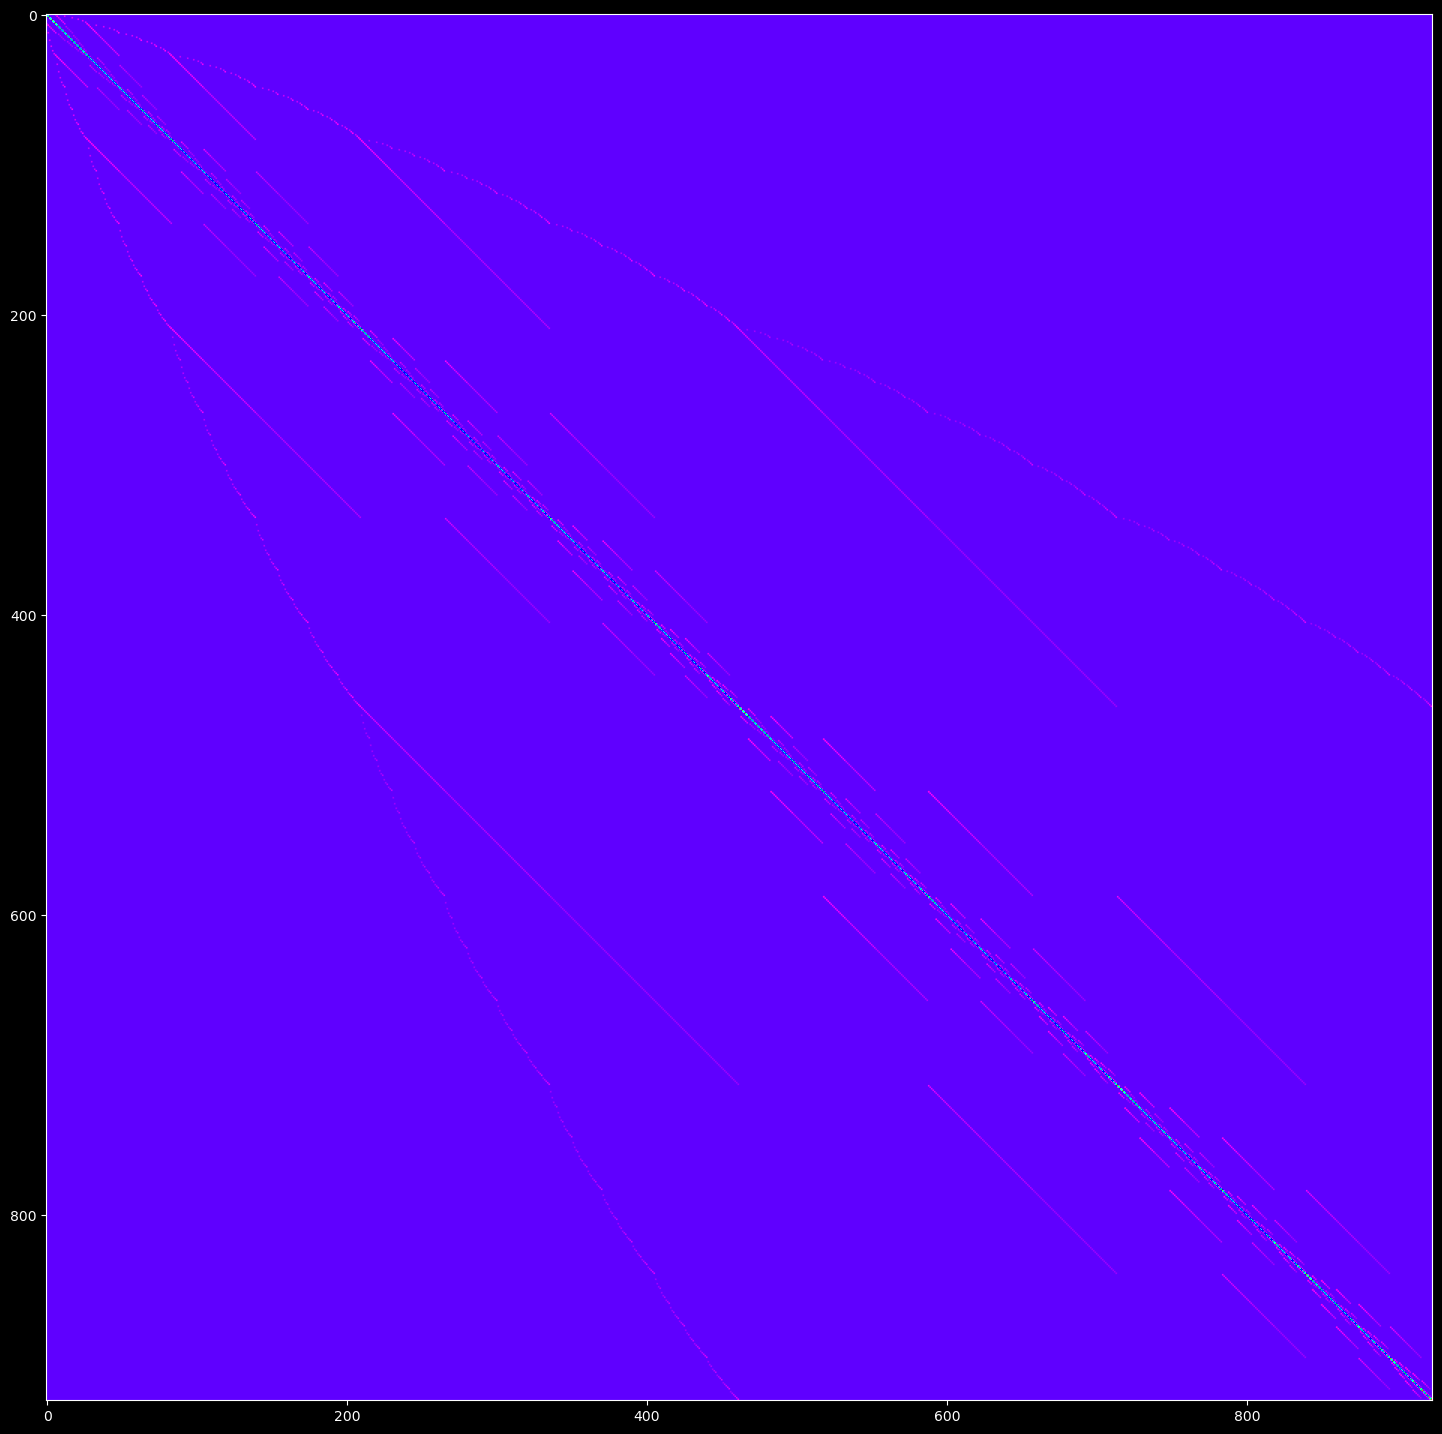

In [6]:
plt.figure(figsize = (18, 18))
plt.imshow(ham, cmap='gist_rainbow')

# Let us now test the spectrum of the Hamiltonian in various packages' routines

In [7]:
import scipy as sp


In [8]:

sparse_ham = sp.sparse.csr_matrix(ham)
k = 500

eigenvalues, eigenvectors = sp.sparse.linalg.eigsh(sparse_ham, k=k, which='SA')


## Plotting the eigenvalues from smallest to largest

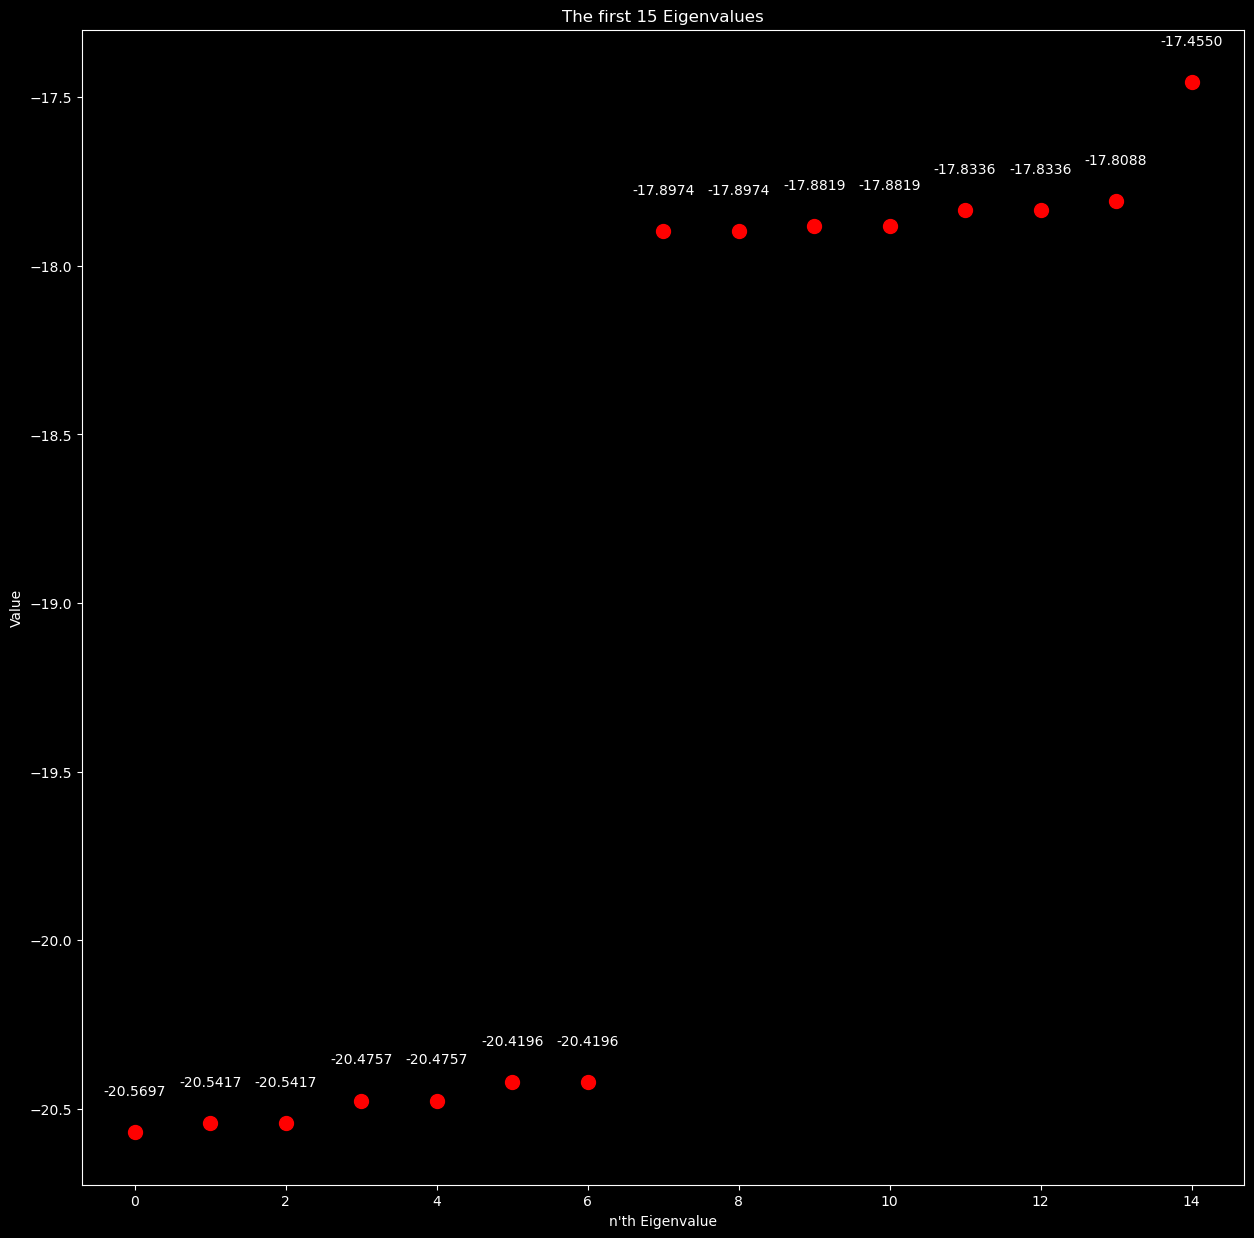

In [21]:
plt.figure(figsize = (15, 15))
plt.plot(eigenvalues[:15], 'o', markersize=10, color='red')
plt.xlabel("n'th Eigenvalue")
plt.ylabel("Value")
plt.title("The first 15 Eigenvalues")

for i in range(15):
    plt.text(i, eigenvalues[i]+0.1, "{:.4f}".format((eigenvalues[i])), ha='center', va='bottom')

plt.show()

## Plotting the eigenvectors (truncated to 200 terms). The first 8 are here

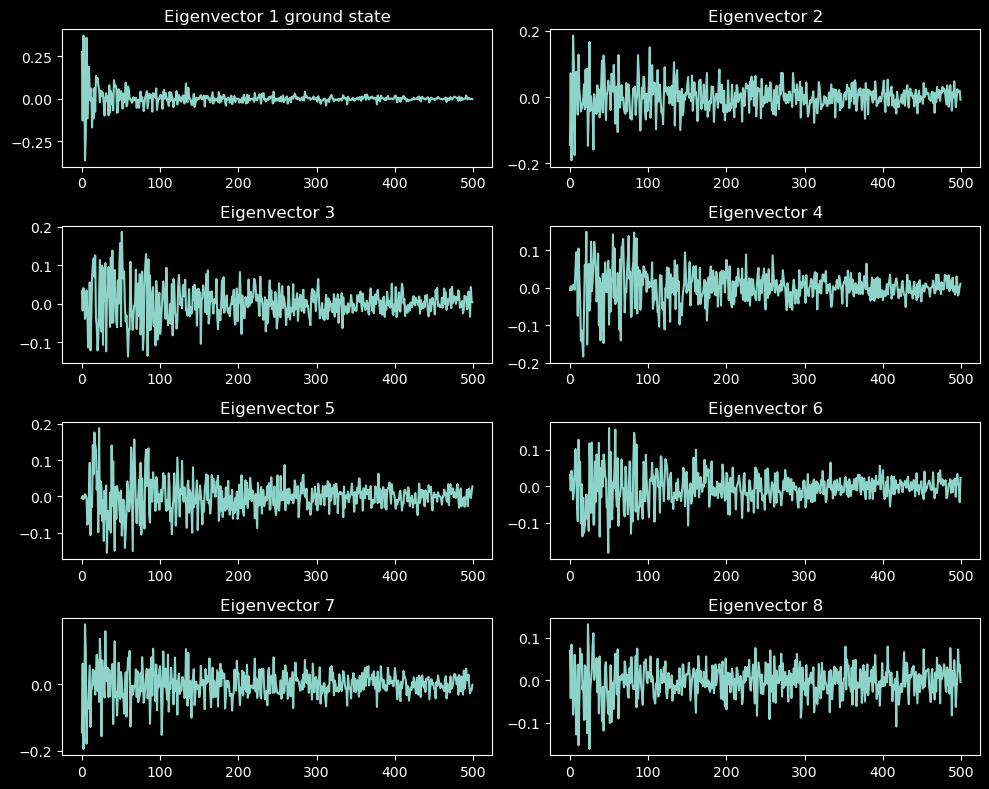

In [22]:
# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(10, 8))

# Set titles for each subplot
titles = ["Eigenvector 1 ground state", "Eigenvector 2", "Eigenvector 3", "Eigenvector 4", "Eigenvector 5", "Eigenvector 6", "Eigenvector 7", "Eigenvector 8"]

for i, ax in enumerate(axs.flat):
    ax.plot(eigenvectors[i])
    ax.set_title(titles[i])

# Automatically adjust subplot layout
plt.tight_layout()

# Show the plot
plt.show()

# Cell below for fermions
## Progress in te fermions basis is slow. The bosons Code cell further up is more complete. It uses mostly abstraction with structs while the fermionic cell tried (unsuccessfully still) to use the more explicit vector representations. Problems still lie in the coding aspect and at the moment there is no plan to continue this version of the representation further as it is deemed too memory inefficient 

In [ ]:
"""
%%cython
cimport cython
from libc.stdlib cimport malloc, free
from cython cimport sizeof
#import numpy as np
#cimport numpy as np



ctypedef struct f_state:
    int* state
    int size

cdef void free_fermions(f_state fstate) nogil:
    free(fstate.state)

@cython.boundscheck(False)
@cython.wraparound(False)
cdef f_state create_fermions(str state, int space_size):
    cdef int* state_array = <int*>malloc(space_size*sizeof(int))
    if state_array is NULL:
        raise MemoryError("Failed to allocate memory for state_array")
    
    for i in range(space_size):
        if state[i] not in ('0', '1'):
            raise ValueError("spinless fermion states can only have 1 occupation or none 0")
        state_array[i] = <int>state[i]-48 #minus 48 because of ascii encoding from str to int. 0 is 48 in ascii. 1 is 49
    cdef f_state fstate
    fstate.state = state_array
    fstate.size = space_size
    return fstate


@cython.boundscheck(False)
@cython.wraparound(False)
cdef int* create_explicit_fermions(f_state in_state):
    cdef int total_size = 2**in_state.size
    cdef int tmp_dimension
    cdef int index
    if in_state.state[0] == 0:
        index = 0
    elif in_state.state[0] == 1:
        index = 1
    if (in_state.size > 1):
        for i in range(in_state.size):
            tmp_dimension = 2**(i+1)
            if (in_state.state[i+1] == 0):
                index = index
            elif (in_state.state[i+1] == 1):
                index = index + tmp_dimension
    cdef int* result = <int*>malloc(total_size*sizeof(int))
    for i in range(total_size):
        result[i] = 0
    result[index] = 1
    return result

    

@cython.boundscheck(False)
@cython.wraparound(False)
cdef int* apply_creator(int k, f_state ket):
    cdef f_state tmp_ket = ket
    cdef int* tmp_ket_explicit
    cdef int const1 = (1-ket.state[k-1])
    cdef int i,j
    for i in range(k-1):
        if ket.state[i] == 1:
            const1 = -const1
    tmp_ket.state[k] = 1
    tmp_ket_explicit = create_explicit_fermions(tmp_ket)
    for j in range(2**tmp_ket.size):
        tmp_ket_explicit[j] = const1*tmp_ket_explicit[j]
    return tmp_ket_explicit
    
        
    





#test unit 2

cdef str fermions = "1110"
cdef int fsize = len(fermions)

print("\nthe state in dirac notation")
cdef f_state fermion_state = create_fermions(fermions, fsize)
for i in range(fsize):
    print(fermion_state.state[i], end=" ")

print("\nthe state in an explicit Fock space vector\n")
cdef int* fermion_vector = create_explicit_fermions(fermion_state)
for i in range(2**fsize):
    print(fermion_vector[i])

    
print("\nNow we want to apply the creator to our 1110 state and get the 1111 state out\n")
cdef str fermions2 = "1111"
cdef int fsize2 = len(fermions2)
cdef f_state fermion2_state = create_fermions(fermions2, fsize2)

cdef int* fermion2_vector = apply_creator(4, fermion_state)
print("\nafter application, the explicit vector looks like this\n")
for i in range(2**fsize):
    print(fermion2_vector[i])

    
print("\nlet's construct the vector explicitly from the state\n")
cdef int* proof = create_explicit_fermions(fermion2_state)
for i in range(2**fsize):
    print(proof[i])
free_fermions(fermion_state)
free(fermion_vector)
free_fermions(fermion2_state)
free(fermion2_vector)
free(proof)


"""